In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
from MEM import MEM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# random data tests

In [9]:
N = 15 
m = 10
X = np.random.rand(N, m)
y = (np.random.randint(0, 2, N) - 1/2)*2

In [3]:
clf = MEM(lmbda=0.1)
clf.fit(X, y)
accuracy_score(np.sign(clf.predict(X)), y)

NameError: name 'accuracy_score' is not defined

In [10]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)

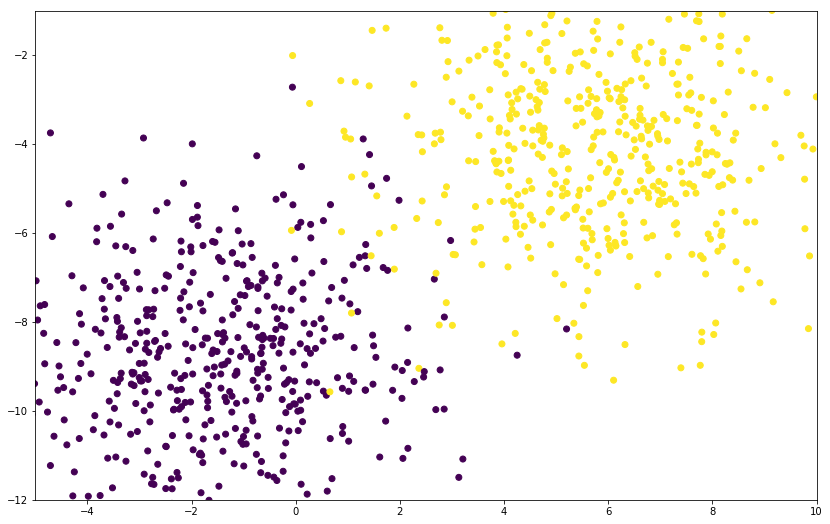

In [525]:
N, m = 1000, 2
(X,y) =  make_blobs(n_samples=N,n_features=m,centers=2,cluster_std=2.05,random_state=40)
#we need to add 1 to X values (we can say its bias)
X1 = np.c_[np.ones((X.shape[0])),X]
y = (y - 0.5)*2

plt.scatter(X1[:,1],X1[:,2],marker='o',c=y)
plt.axis([-5,10,-12,-1])
plt.show()

In [535]:
clf = MEM(lmbda=0.1)
clf.fit(X, y)
accuracy_score(np.sign(clf.predict(X)), y)

0.981

In [536]:
clf.predict_proba(X)

array([1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 6.45504098e-01, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
      

## proba

# read datasets

In [11]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

it will be grate to add credit, promoters

In [12]:
dataset_names = [elem.split('.')[0] for elem in os.listdir('data')]
dataset_names

['adult',
 'adult',
 'crx',
 'hepatitis',
 'house-votes-84',
 'kr-vs-kp',
 'promoters',
 'synth']

In [13]:
dfs = []
for elem in os.listdir('data'):
    if elem.endswith('.data'):
        dfs.append(pd.read_csv('data/' + elem, header=None).replace('?', np.nan))
        dfs[-1].fillna(dfs[-1].mode().iloc[0], inplace=True)
        print(elem, ' ', len(dfs[-1]))
    
columns = list(dfs[0].columns)
columns = columns[1:] + [columns[0]]
ind = dataset_names.index('house-votes-84')
dfs[ind] = dfs[ind].reindex(columns=columns)

ind = dataset_names.index('adult')
dfs[ind] = dfs[ind].drop([2], axis=1)

adult.data   32561
crx.data   690
hepatitis.data   155
house-votes-84.data   435
kr-vs-kp.data   3196
promoters.data   106
synth.data   200


In [14]:
def extract_data(df, discrete=False):
    df = df.drop([df.columns[-1]], axis=1)
    if discrete:
        X = pd.get_dummies(df, columns=df.columns).values
    else:
        X = pd.get_dummies(df).values
    y = df[df.columns[-1]].values
    return X, y

In [15]:
lb = LabelEncoder()
data = []
for df in dfs:
    X, y = extract_data(df)
    y = (lb.fit_transform(y) - 0.5)*2
    data.append([X, y])

In [16]:
lb = LabelEncoder()
discrete_data = []
for df in dfs:
    X, y = extract_data(df, True)
    y = (lb.fit_transform(y) - 0.5)*2
    discrete_data.append([X, y])

# set up experiment

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

In [150]:
def process_clf(clf, num_iters, data=data):
    results = [[] for _ in range(len(data))]
    for i in tqdm(range(num_iters)):
        for j, (X, y) in enumerate(data):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
            clf.fit(X_train, y_train)
            results[j].append(1 - accuracy_score(y_test, clf.predict(X_test)))
    results = np.array(results)
    mean, var = results.mean(axis=1), results.var(axis=1)
    for name, vmean, vvar in zip(dataset_names, mean, var):
        print(f'{name:<15} mean: {vmean:<5},\t var: {vvar}')
    return 

In [521]:
process_clf(LogisticRegression(solver='lbfgs', max_iter=300), 100)

house-votes-84  mean: 0.038473282442748086,	 var: 0.0002260008158032744
hepatitis       mean: 0.3427659574468086,	 var: 0.002932503395201449
kr-vs-kp        mean: 0.03688216892596451,	 var: 3.948445167400454e-05
adult           mean: 0.2018865799979527,	 var: 3.5711799985751346e-05


In [538]:
process_clf(MEM(), 3)

house-votes-84  mean: 0.05343511450381677,	 var: 3.8847774993687364e-05
hepatitis       mean: 0.30496453900709225,	 var: 0.0013077812987274283
kr-vs-kp        mean: 0.029197080291970767,	 var: 2.6820894056381074e-05
adult           mean: 0.30067901866448293,	 var: 0.002820511465470537


In [20]:
##hyperparametrs for MEM
lmbda_range = np.random.permutation([2**x for x in range(-10, 7)])
lmbda_score = np.zeros((lmbda_range.shape[0], len(data)))
print('Dataset\tlambda\taccuracy')
i=0
for x in lmbda_range:
    for j, (X, y) in (enumerate(data)):
        X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        mem = MEM(lmbda=x)
        X_train_lmbda, X_test_lmbda, y_train_lmbda, y_test_lmbda = train_test_split(X_train, y_train, 
                                                                                    test_size=0.3, shuffle=True)
        mem.fit(X_train_lmbda, y_train_lmbda)
        lmbda_score[i, j] = accuracy_score(y_test_lmbda, mem.predict(X_test_lmbda))
        print('\n',j, x, lmbda_score[i, j])
    i+=1

Dataset	lambda	accuracy


KeyboardInterrupt: 

In [ ]:
lmbda_opt= lmbda_range[np.amax(lmbda_score, axis=0)]

In [29]:
from sklearn.svm import SVC

In [14]:
process_clf(SVC(kernel='linear'), 3)


house-votes-84  mean: 0.050890585241730256,	 var: 1.2949258331229122e-05
hepatitis       mean: 0.3404255319148936,	 var: 0.000905387052965142
kr-vs-kp        mean: 0.03058741744873128,	 var: 4.083541527503065e-05
adult           mean: 0.20053229603848907,	 var: 1.6437298762501597e-05


In [ ]:
##hyperparametrs for SVC
C = np.random.permutation([2**x for x in range(-5, 5)])
C_score = np.zeros((len(C), len(data)))
print('Dataset\t\tC\taccuracy')
i=0
for c in C:
    lmbda_score = np.zeros(len(lmbda_range))
    for j, (X, y) in (enumerate(data)):
        X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        svc = SVC(kernel='linear', C=c)
        X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)
        
        svc.fit(X_train_lmbda, y_train_lmbda)
        С_score[i, j] = accuracy_score(y_test_C, svc.predict(X_test_C))
        print('\n',j, x, С_score[i, j])
    i+=1

In [ ]:
С_opt = lmbda_range[np.amax(С_score, axis=0)]

# DRC

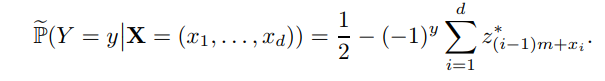

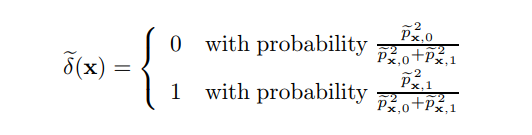

In [18]:
from DRC import DRC

In [94]:
clf = DRC()
clf.fit(X, y)
accuracy_score(clf.predict(X), y)

1.0

In [ ]:
process_clf(DRC(), 3, discrete_data)

In [106]:
clf = DRC()
num_iters = 3
results = [[] for _ in range(len(data[::2]))]
for i in tqdm(range(num_iters)):
    for j, (X, y) in enumerate(data[::2]):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        clf.fit(X_train, y_train)
        results[j].append(1 - accuracy_score(y_test, clf.predict(X_test)))
results = np.array(results)
mean, var = results.mean(axis=1), results.var(axis=1)
for name, vmean, vvar in zip(dataset_names[::2], mean, var):
    print(f'{name:<15} mean: {vmean:<5},\t var: {vvar}')


house-votes-84  mean: 0.050890585241730256,	 var: 1.2949258331229122e-05
kr-vs-kp        mean: 0.06256517205422318,	 var: 8.69866834261008e-06


In [21]:
##hyperparameters for DRC
lmbda_range = np.random.permutation([2**x for x in range(-7, 6)])
lmbda_score_drc = np.zeros((lmbda_range.shape[0], len(discrete_data)))
print('Dataset\tlambda\taccuracy')
i=0
for x in lmbda_range:
    for j, (X, y) in (enumerate(discrete_data)):
        X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        drc = DRC(lmbda=x)
        X_train_lmbda, X_test_lmbda, y_train_lmbda, y_test_lmbda = train_test_split(X_train, y_train, 
                                                                                    test_size=0.3, shuffle=True)
        drc.fit(X_train_lmbda, y_train_lmbda)
        lmbda_score_drc[i, j] = accuracy_score(y_test_lmbda, drc.predict(X_test_lmbda))
        print('\n',j, x, lmbda_score_drc[i, j])
    i+=1

Dataset	lambda	accuracy


KeyboardInterrupt: 

In [ ]:
lmbda_opt= lmbda_range[np.amax(lmbda_score, axis=0)]

# TAN

In [24]:
import pytan

In [ ]:
process_clf(pytan.DiscreteBayesNetClassifier(), 3, discrete_data)

In [ ]:
##hyperparameters for DRC
alpha_range = np.random.permutation([2**x for x in range(-6, 5)])
alpha_score = np.zeros((alpha_range.shape[0], len(discrete_data)))
print('Dataset\talpha\taccuracy')
i=0
for x in alpha_range:
    for j, (X, y) in (enumerate(discrete_data)):
        X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        tan = pytan.DiscreteBayesNetClassifier(alpha=x)
        X_train_lmbda, X_test_lmbda, y_train_lmbda, y_test_lmbda = train_test_split(X_train, y_train, 
                                                                                    test_size=0.3, shuffle=True)
        tan.fit(X_train_lmbda, y_train_lmbda)
        alpha_score[i, j] = accuracy_score(y_test_lmbda, tan.predict(X_test_lmbda))
        print('\n',j, x, alpha_score[i, j])
    i+=1

Dataset		accuracy


In [ ]:
alpha_opt= lmbda_range[np.amax(alpha_score, axis=0)]